# init

In [1]:
from methods import *

# the numpy arrays need to match the same floating type used by pytorch here
th.set_default_dtype(th.float32)

# remove some annoying tensorflow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 'spawn' is needed to use gpus in parallel for pytorch
mp.set_start_method('spawn')

# set device to load pytorch models and data onto
device = 'cuda:1'

cpu count: 20
gpu count: 3
cuda avail: True


# read and proc data

In [2]:
# read data
prepared_datasets_path = '/home/tim/Dropbox/data/prepared_datasets/'
n_samples = 1_000

predictor_train = np.load(f'{prepared_datasets_path}rgb_to_depth_v1/train_rgb.npy')
target_train = np.load(f'{prepared_datasets_path}rgb_to_depth_v1/train_depth.npy')
predictor_eval = np.load(f'{prepared_datasets_path}rgb_to_depth_v1/test_rgb.npy')
target_eval = np.load(f'{prepared_datasets_path}rgb_to_depth_v1/test_depth.npy')

# predictor_train = np.random.randint(1,255,[n_samples,3,144,256]).astype(np.uint8)
# predictor_eval = np.random.randint(1,255,[n_samples,3,144,256]).astype(np.uint8)
# target_train = np.random.randint(1,255,[n_samples,1,144,256]).astype(np.uint8)
# target_eval = np.random.randint(1,255,[n_samples,1,144,256]).astype(np.uint8)

predictor_mean = 94.11807077041952 #np.mean(predictor_train)
predictor_std = 80.77841523336176 #np.std(predictor_train)
target_min = 0
target_max = 255

def x_preproc_func(x, _mean, _std):
    return (x.astype(np.float32)-_mean)/_std
def y_preproc_func(y, _min, _max):
    return (y.astype(np.float32)-_min)/(_max-_min)
x_preproc_params={'_mean':predictor_mean, '_std':predictor_std}
y_preproc_params={'_min':target_min, '_max':target_max}
def unprocess_func(p, _min, _max):
    p = (p*(_max-_min)+_min).astype(np.uint8)
    p[p==0] = 1
    return p
unprocess_params={'_min':target_min, '_max':target_max}

# extract parameters from input/ouput data
n_instances = predictor_train.shape[0]
n_channels = predictor_train.shape[1]
n_dim1 = predictor_train.shape[2]
n_dim2 = predictor_train.shape[3]

print(predictor_train.shape, target_train.shape)
print(predictor_eval.shape, target_eval.shape)

(99480, 3, 144, 256) (99480, 1, 144, 256)
(95608, 3, 144, 256) (95608, 1, 144, 256)


In [3]:
# # calucate statistics to standardize (done during dataloader)

# R = predictor_train[:,0,:,:].flatten()
# G = predictor_train[:,1,:,:].flatten()
# B = predictor_train[:,2,:,:].flatten()

# mean_R, std_R = np.mean(R), np.std(R)
# mean_G, std_G = np.mean(G), np.std(G)
# mean_B, std_B = np.mean(B), np.std(B)

# means = np.array([mean_R, mean_G, mean_B])
# stds = np.array([std_R, std_G, std_B])

# SET PARALLELIZATION

In [4]:
hyper_parallel = False
gpu_threads = 1
cpu_threads = 4

# set model architecture

In [5]:
# make a scalable CNN following Zixia's depth network which is inspired by: https://ieeexplore.ieee.org/abstract/document/9318521
scale = 1
model_func = create_cnn
model_params = {
    'block_layers':[
                    [
                        [nn.Conv2d, {'in_channels':n_channels, 'out_channels':int(32*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                        [nn.BatchNorm2d, {'num_features':int(32*scale)}],
                        [nn.SELU],
                    ],
                    [
                        [nn.Conv2d, {'in_channels':int(32*scale), 'out_channels':int(64*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                        [nn.BatchNorm2d, {'num_features':int(64*scale)}],
                        [nn.SELU],
                    ],
                    [
                        [nn.Conv2d, {'in_channels':int(64*scale), 'out_channels':int(128*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                        [nn.BatchNorm2d, {'num_features':int(128*scale)}],
                        [nn.SELU],
                    ],
                    [
                        [nn.Conv2d, {'in_channels':int(128*scale), 'out_channels':int(256*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                        [nn.BatchNorm2d, {'num_features':int(256*scale)}],
                        [nn.SELU],
                    ],
                    [
                        [nn.Conv2d, {'in_channels':int(256*scale), 'out_channels':int(256*scale), 'kernel_size':3, 'dilation':2, 'padding':2}],
                        [nn.BatchNorm2d, {'num_features':int(256*scale)}],
                        [nn.SELU],
                    ],
                    [
                        [nn.Conv2d, {'in_channels':int(256*scale), 'out_channels':int(256*scale), 'kernel_size':3, 'dilation':4, 'padding':4}],
                        [nn.BatchNorm2d, {'num_features':int(256*scale)}],
                        [nn.SELU],
                    ],
                    [
                        [nn.Conv2d, {'in_channels':int(256*scale), 'out_channels':int(256*scale), 'kernel_size':3, 'dilation':2, 'padding':2}],
                        [nn.BatchNorm2d, {'num_features':int(256*scale)}],
                        [nn.SELU],
                    ],
                    [
                        [nn.ConvTranspose2d, {'in_channels':int(256*scale), 'out_channels':int(128*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                        [nn.BatchNorm2d, {'num_features':int(128*scale)}],
                        [nn.SELU],
                    ],
                    [
                        [nn.ConvTranspose2d, {'in_channels':int(128*scale), 'out_channels':int(64*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                        [nn.BatchNorm2d, {'num_features':int(64*scale)}],
                        [nn.SELU],
                    ],
                    [
                        [nn.ConvTranspose2d, {'in_channels':int(64*scale), 'out_channels':int(32*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                        [nn.BatchNorm2d, {'num_features':int(32*scale)}],
                        [nn.SELU],
                    ],
                    [
                        [nn.ConvTranspose2d, {'in_channels':int(32*scale), 'out_channels':int(32*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                        [nn.BatchNorm2d, {'num_features':int(32*scale)}],
                        [nn.SELU],
                        [nn.Conv2d, {'in_channels':int(32*scale), 'out_channels':int(32*scale), 'kernel_size':3, 'padding':1}],
                        [nn.SELU],
                        [nn.Conv2d, {'in_channels':int(32*scale), 'out_channels':int(1), 'kernel_size':1, 'stride':1, 'padding':0}],
                        [nn.Sigmoid],
                    ],
                    # [
                    #     [nn.Flatten],
                    #     [mlp_modules, {
                    #         'layers':[n_preds,1024,512,64,n_targets],
                    #         'dropout':[0.2,0.2,0.2,0.2,0.2],
                    #         'hid_activation':nn.ELU,
                    #         'out_activation':nn.Sigmoid,
                    #         }],
                    # ],
               ]
}
model = model_func(**model_params).to(device)
model

# view dimensions at each layer of network
print('stride = 2')
x = th.tensor(predictor_train[:100].astype(np.float32)).to(device)
print('input', x.size())
for m_idx, module in enumerate(model):
    x = module(x)
    print('layer', m_idx+1, x.size())

del model
del x

stride = 2
input torch.Size([100, 3, 144, 256])
layer 1 torch.Size([100, 32, 72, 128])
layer 2 torch.Size([100, 64, 36, 64])
layer 3 torch.Size([100, 128, 18, 32])
layer 4 torch.Size([100, 256, 9, 16])
layer 5 torch.Size([100, 256, 9, 16])
layer 6 torch.Size([100, 256, 9, 16])
layer 7 torch.Size([100, 256, 9, 16])
layer 8 torch.Size([100, 128, 18, 32])
layer 9 torch.Size([100, 64, 36, 64])
layer 10 torch.Size([100, 32, 72, 128])
layer 11 torch.Size([100, 1, 144, 256])


# MAKE PARAMETERS FOR ALL RUNS + RUN_NAMES

In [6]:
# organize all runs
cross_validation_params = []
prediction_params = []
benchmark_params = []
run_names = []
n_runs = 1
criterion = nn.L1Loss()
error_func = mean_absolute_percent_error_tensor
patience = 10
n_epochs = 10
for run_idx in range(n_runs):
    random_seed = run_idx
    run_name = f'{run_idx}'
    run_names.append(run_name)
    cv_params = {
        'force_overwrite':True,
        'run_name':run_name,
        'random_seed':random_seed,
        'force_overwrite':True,
        'nFolds':1,
        'splits':[0.8, 0.2, 0.0],
        'device':device,
        'model_func':create_cnn,
        'model_params':model_params,
        'criterion':criterion,
        'error_func':error_func,
        'patience':n_epochs, 
        'max_epochs':n_epochs,
        'mem_optim':True,
    }
    p_params = {
        'run_name':run_name,
        'device':device,
    }
    b_params = {
        'run_name':run_name,
        'err_funcs':{'r2':r2_score,'mape':mean_absolute_percent_error_numpy},
        'device':device,
    }
    cross_validation_params.append(cv_params)
    prediction_params.append(p_params)
    benchmark_params.append(b_params)

print(len(run_names), 'runs')

1 runs


# MAKE TRAINER TO RUN JOBS

In [7]:
# expand dimensions into groups to be used by my cross validation code
predictor_train = np.expand_dims(predictor_train,1)
target_train = np.expand_dims(target_train,1)
predictor_eval = np.expand_dims(predictor_eval,1)
target_eval = np.expand_dims(target_eval,1)

experiment_name = 'init'
parent_folder='results/'
trainer = Trainer(experiment_name, predictor_train, target_train, predictor_eval, target_eval, parent_folder, 
                  x_preproc_func, x_preproc_params, y_preproc_func, y_preproc_params, unprocess_func, unprocess_params)

# RUN LIGHTWEIGHT JOBS - TRAIN/EVAL MODELS BUT DO NOT SAVE THEM

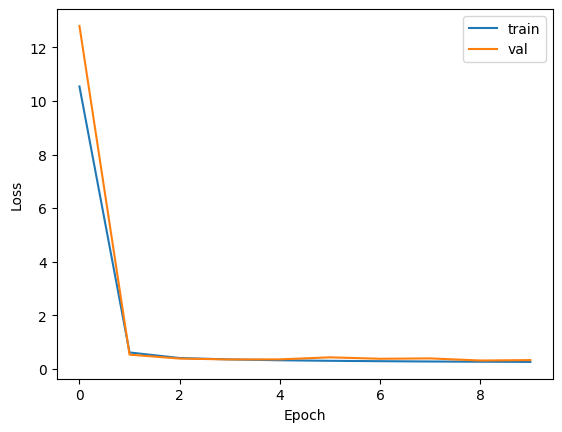

1 runs after


In [8]:
print(len(os.listdir(trainer.runs_path)), 'runs before')

job_params = [['lightweight_job', {'run_name':run_name, 
               'delete_model':False,'force_overwrite':False, 'fold':0, 
'cross_validation_params':cross_validation_params[i], 'prediction_params':prediction_params[i], 'benchmark_params':benchmark_params[i],}
            ] for i, run_name in enumerate(run_names)]
        
if hyper_parallel:
    trainer.run_jobs(job_params, gpu_threads)
else:
    for job_param in job_params:
        trainer.single_job(job_param[0], job_param[1])
                         
print(len(os.listdir(trainer.runs_path)), 'runs after')

In [9]:
trainer.combine_benchmarks()
pk.load(open(trainer.experiment_path + 'benchmarks.p', 'rb'))

{'0': {'r2': {'train': 0.7957348289530048,
   'val': 0.7308315262481205,
   'eval': 0.7756999872691589},
  'mape': {'train': 14.397195663008256,
   'val': 23.211274695354113,
   'eval': 13.143475004139312}}}

In [9]:
trainer.combine_benchmarks()
pk.load(open(trainer.experiment_path + 'benchmarks.p', 'rb'))

{'0': {'r2': {'train': 0.7957348289530048,
   'val': 0.7308315262481205,
   'eval': 0.7756999872691589},
  'mape': {'train': 14.397195663008256,
   'val': 23.211274695354113,
   'eval': 13.143475004139312}}}

In [ ]:
# # dummy data
# predictor_train = np.random.randint(1,255,[1_000,3,144,256]).astype(np.float32)
# predictor_eval = np.random.randint(1,255,[1_000,3,144,256]).astype(np.float32)
# target_train = np.random.randint(1,255,[1_000,1,144,256]).astype(np.float32)
# target_eval = np.random.randint(1,255,[1_000,1,144,256]).astype(np.float32)
# # extract parameters from input/ouput data
# n_instances = predictor_train.shape[0]
# n_channels = predictor_train.shape[1]
# n_dim1 = predictor_train.shape[2]
# n_dim2 = predictor_train.shape[3]

In [ ]:
# # make a scalable CNN following Zixia's depth network which is inspired by: https://ieeexplore.ieee.org/abstract/document/9318521
# scale = 1
# model_func = create_cnn
# model_params = {
#     'block_layers':[
#                     [
#                         [nn.Conv2d, {'in_channels':n_channels, 'out_channels':int(32*scale), 'kernel_size':4, 'stride':3}],
#                         [nn.BatchNorm2d, {'num_features':int(32*scale)}],
#                         [nn.SELU],
#                     ],
#                     [
#                         [nn.Conv2d, {'in_channels':int(32*scale), 'out_channels':int(64*scale), 'kernel_size':4, 'stride':3}],
#                         [nn.BatchNorm2d, {'num_features':int(64*scale)}],
#                         [nn.SELU],
#                     ],
#                     [
#                         [nn.Conv2d, {'in_channels':int(64*scale), 'out_channels':int(128*scale), 'kernel_size':4, 'stride':3}],
#                         [nn.BatchNorm2d, {'num_features':int(128*scale)}],
#                         [nn.SELU],
#                     ],
#                     [
#                         [nn.Conv2d, {'in_channels':int(128*scale), 'out_channels':int(256*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
#                         [nn.BatchNorm2d, {'num_features':int(256*scale)}],
#                         [nn.SELU],
#                     ],
#                     [
#                         [nn.Conv2d, {'in_channels':int(256*scale), 'out_channels':int(256*scale), 'kernel_size':3, 'dilation':2, 'padding':2}],
#                         [nn.BatchNorm2d, {'num_features':int(256*scale)}],
#                         [nn.SELU],
#                     ],
#                     [
#                         [nn.Conv2d, {'in_channels':int(256*scale), 'out_channels':int(256*scale), 'kernel_size':3, 'dilation':4, 'padding':4}],
#                         [nn.BatchNorm2d, {'num_features':int(256*scale)}],
#                         [nn.SELU],
#                     ],
#                     [
#                         [nn.Conv2d, {'in_channels':int(256*scale), 'out_channels':int(256*scale), 'kernel_size':3, 'dilation':2, 'padding':2}],
#                         [nn.BatchNorm2d, {'num_features':int(256*scale)}],
#                         [nn.SELU],
#                     ],
#                     [
#                         [nn.ConvTranspose2d, {'in_channels':int(256*scale), 'out_channels':int(128*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
#                         [nn.BatchNorm2d, {'num_features':int(128*scale)}],
#                         [nn.SELU],
#                     ],
#                     [
#                         [nn.ConvTranspose2d, {'in_channels':int(128*scale), 'out_channels':int(64*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
#                         [nn.BatchNorm2d, {'num_features':int(64*scale)}],
#                         [nn.SELU],
#                     ],
#                     [
#                         [nn.ConvTranspose2d, {'in_channels':int(64*scale), 'out_channels':int(32*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
#                         [nn.BatchNorm2d, {'num_features':int(32*scale)}],
#                         [nn.SELU],
#                     ],
#                     [
#                         [nn.ConvTranspose2d, {'in_channels':int(32*scale), 'out_channels':int(32*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
#                         [nn.BatchNorm2d, {'num_features':int(32*scale)}],
#                         [nn.SELU],
#                         [nn.Conv2d, {'in_channels':int(32*scale), 'out_channels':int(32*scale), 'kernel_size':3, 'padding':1}],
#                         [nn.SELU],
#                         [nn.Conv2d, {'in_channels':int(32*scale), 'out_channels':int(1), 'kernel_size':1, 'stride':1, 'padding':0}],
#                         [nn.Sigmoid],
#                     ],
#                     # [
#                     #     [nn.Flatten],
#                     #     [mlp_modules, {
#                     #         'layers':[n_preds,1024,512,64,n_targets],
#                     #         'dropout':[0.2,0.2,0.2,0.2,0.2],
#                     #         'hid_activation':nn.ELU,
#                     #         'out_activation':nn.Sigmoid,
#                     #         }],
#                     # ],
#                ]
# }
# model = model_func(**model_params).to(device)
# model

# # view dimensions at each layer of network
# x = th.tensor(predictor_train[:100]).to(device)
# print('stride = 3')
# print('input', x.size())
# for m_idx, module in enumerate(model):
#     x = module(x)
#     print('layer', m_idx+1, x.size())

In [ ]:
# # make a scalable CNN following Zixia's depth network which is inspired by: https://ieeexplore.ieee.org/abstract/document/9318521
# scale = 1
# model_func = create_cnn
# model_params = {
#     'block_layers':[
#                     [
#                         [nn.Conv2d, {'in_channels':n_channels, 'out_channels':int(32*scale), 'kernel_size':4, 'stride':3}],
#                         [nn.BatchNorm2d, {'num_features':int(32*scale)}],
#                         [nn.SELU],
#                     ],
#                     [
#                         [nn.Conv2d, {'in_channels':int(32*scale), 'out_channels':int(64*scale), 'kernel_size':4, 'stride':3}],
#                         [nn.BatchNorm2d, {'num_features':int(64*scale)}],
#                         [nn.SELU],
#                     ],
#                     [
#                         [nn.Conv2d, {'in_channels':int(64*scale), 'out_channels':int(128*scale), 'kernel_size':4, 'stride':3}],
#                         [nn.BatchNorm2d, {'num_features':int(128*scale)}],
#                         [nn.SELU],
#                     ],
#                     [
#                         [nn.ConvTranspose2d, {'in_channels':int(128*scale), 'out_channels':int(128*scale), 'kernel_size':(3,2), 'stride':(3,4), 'dilation':(5,3), 'padding':(1,2)}],
#                         [nn.BatchNorm2d, {'num_features':int(128*scale)}],
#                         [nn.SELU],
#                     ],
#                     [
#                         [nn.Conv2d, {'in_channels':int(128*scale), 'out_channels':int(256*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
#                         [nn.BatchNorm2d, {'num_features':int(256*scale)}],
#                         [nn.SELU],
#                     ],
#                     [
#                         [nn.Conv2d, {'in_channels':int(256*scale), 'out_channels':int(256*scale), 'kernel_size':3, 'dilation':2, 'padding':2}],
#                         [nn.BatchNorm2d, {'num_features':int(256*scale)}],
#                         [nn.SELU],
#                     ],
#                     [
#                         [nn.Conv2d, {'in_channels':int(256*scale), 'out_channels':int(256*scale), 'kernel_size':3, 'dilation':4, 'padding':4}],
#                         [nn.BatchNorm2d, {'num_features':int(256*scale)}],
#                         [nn.SELU],
#                     ],
#                     [
#                         [nn.Conv2d, {'in_channels':int(256*scale), 'out_channels':int(256*scale), 'kernel_size':3, 'dilation':2, 'padding':2}],
#                         [nn.BatchNorm2d, {'num_features':int(256*scale)}],
#                         [nn.SELU],
#                     ],
#                     [
#                         [nn.ConvTranspose2d, {'in_channels':int(256*scale), 'out_channels':int(128*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
#                         [nn.BatchNorm2d, {'num_features':int(128*scale)}],
#                         [nn.SELU],
#                     ],
#                     [
#                         [nn.ConvTranspose2d, {'in_channels':int(128*scale), 'out_channels':int(64*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
#                         [nn.BatchNorm2d, {'num_features':int(64*scale)}],
#                         [nn.SELU],
#                     ],
#                     [
#                         [nn.ConvTranspose2d, {'in_channels':int(64*scale), 'out_channels':int(32*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
#                         [nn.BatchNorm2d, {'num_features':int(32*scale)}],
#                         [nn.SELU],
#                     ],
#                     [
#                         [nn.ConvTranspose2d, {'in_channels':int(32*scale), 'out_channels':int(32*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
#                         [nn.BatchNorm2d, {'num_features':int(32*scale)}],
#                         [nn.SELU],
#                         [nn.Conv2d, {'in_channels':int(32*scale), 'out_channels':int(32*scale), 'kernel_size':3, 'padding':1}],
#                         [nn.SELU],
#                         [nn.Conv2d, {'in_channels':int(32*scale), 'out_channels':int(1), 'kernel_size':1, 'stride':1, 'padding':0}],
#                         [nn.Sigmoid],
#                     ],
#                     # [
#                     #     [nn.Flatten],
#                     #     [mlp_modules, {
#                     #         'layers':[n_preds,1024,512,64,n_targets],
#                     #         'dropout':[0.2,0.2,0.2,0.2,0.2],
#                     #         'hid_activation':nn.ELU,
#                     #         'out_activation':nn.Sigmoid,
#                     #         }],
#                     # ],
#                ]
# }
# model = model_func(**model_params).to(device)
# model

# # view dimensions at each layer of network
# x = th.tensor(predictor_train[:100]).to(device)
# print('stride = 3 -- adjusted ')
# print('input', x.size())
# for m_idx, module in enumerate(model):
#     x = module(x)
#     print('layer', m_idx+1, x.size())

In [ ]:
# # MLP all flattened
# model_func = create_mlp
# model_params = {
#     #'layers':[n_preds,128,64,64,32,16,n_targets],
#     #'dropout':[0,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2],
#     'layers':[n_preds,1024,1024,512,256,64,n_targets],
#     'hid_activation':nn.ELU,
#     'out_activation':nn.Sigmoid,
#     }
# model = model_func(**model_params).to('cpu')
# model